In [1]:
import json

import torch
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from datasets import get_CIFAR10, get_SVHN, postprocess, preprocess
from model import Glow


device = torch.device("cuda")

output_folder = 'output/'
model_name = './weights/glow/glow_affine_coupling.pth'

conf = OmegaConf.load('config.yaml')    

image_shape, num_classes, data, test_cifar = get_CIFAR10(conf.augment, conf.dataroot, conf.download)
image_shape, num_classes, _, test_svhn = get_SVHN(conf.augment, conf.dataroot, conf.download)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../../../data/SVHN/train_32x32.mat
Using downloaded and verified file: ../../../data/SVHN/test_32x32.mat


## CHECK SAMPLING

In [2]:
conf.K = 32
conf.L = 3
conf.LU_decomposed = True
conf.learn_top = True

In [3]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

model.load_state_dict(torch.load(model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

In [4]:
def sample(model):
    with torch.no_grad():
        if conf.y_condition:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=0.8, reverse=True))
    return images.cpu()

In [5]:
def min_max(arr):
    mn = arr.min()
    mx = arr.max()
    return (arr - mn)/(mx-mn)

Call forward
Call forward


(-0.5, 205.5, 171.5, -0.5)

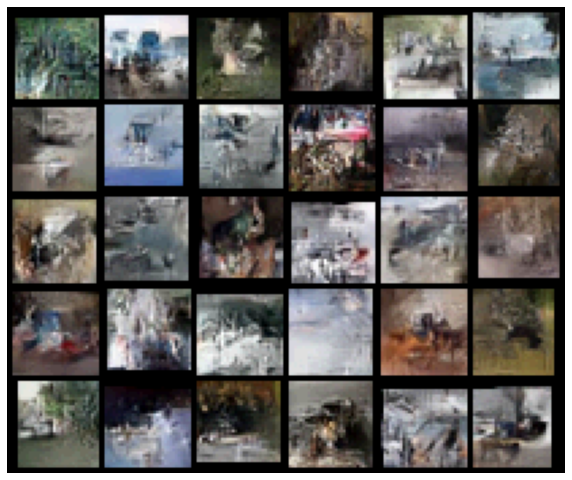

In [6]:
images = sample(model)
grid = make_grid(images[:30], nrow=6, normalize=False).permute(1,2,0).numpy()

plt.figure(figsize=(10,10))
plt.imshow(min_max(grid))
plt.axis('off')

# CHECK DIRECT FLOW

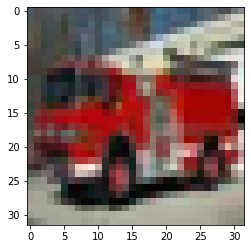

In [7]:
idx = 23
plt.imshow(test_cifar.data[idx])

In [8]:
convert_to_tensor = transforms.ToTensor()

In [9]:
img_tensor =  preprocess(convert_to_tensor(test_cifar.data[idx])).unsqueeze(0)
print(f'tensor shape {img_tensor.shape}')

tensor shape torch.Size([1, 3, 32, 32])


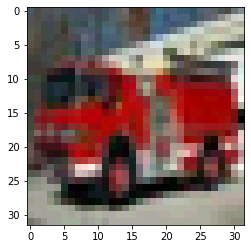

In [10]:
img_from_tensor = img_tensor.squeeze(0).permute(1,2,0).numpy()
plt.imshow(min_max(img_from_tensor))

In [11]:
img_tensor = img_tensor.to(device)
z, _, _ = model(x=img_tensor, reverse=False)
print(f'Out shape: {z.shape}')

Call forward
Call forward
Out shape: torch.Size([1, 48, 4, 4])


In [30]:
#zero = torch.zeros_like(z)
z_back =  model(z=z, y_onehot=None, temperature=None, reverse=True)

Call forward
Reverse & T is none
Call forward
Reverse & T is none


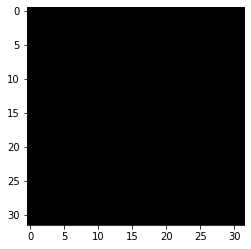

In [31]:
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))